**Qingbo Liu**

Spring 2020

CS 251B: Data Analysis and Visualization

Project 3: Linear regression

QR-based linear regression and polynomial regression

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

import data
import linear_regression

plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])
plt.rcParams.update({'font.size': 20})

np.set_printoptions(suppress=True, precision=5)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

## Notes

- In your implementations, only the following "high level" `scipy`/`numpy` functions can be used:
    - `np.linalg.inv`
    - `scipy.linalg.lstsq` (in `LinearRegression::linear_regression_scipy` only).
    - `np.linalg.norm`
    - (LA section only): `scipy.linalg.solve_triangular`, 

## Task 4: Implement a QR based linear regression solver

### 4a) QR-decomposition

- Write algorithm to compute QR decomposition (`linear_regression::qr_decomposition`). **Run test code below.** Equation for R: $$R = Q^TA$$
- Implement `linear_regression::linear_regression_qr` to use the QR decomposition to do the linear regression. Recall that the equation is $$Rc = Q^Ty$$ which can be solved without taking the inverse of $R$ through backsolving.

#### Test QR decomposition

In [23]:
iris_filename = 'data/iris.csv'
iris_data = data.Data(iris_filename)

A = iris_data.select_data(['sepal_length', 'petal_width'])
A1 = np.hstack([A, np.ones([len(A), 1])])

lin_reg_qr = linear_regression.LinearRegression(iris_data)
myQ, myR = lin_reg_qr.qr_decomposition(A1)

Q, R = np.linalg.qr(A1)

print('NOTE: It is ok if everything is GLOBALLY negated.\n')
print(f'Your Q shape is {myQ.shape} and should be {Q.shape}')
print(f'Your R shape is {myR.shape} and should be {R.shape}')
print(f'1st few rows of your Q are\n{myQ[:3]} and should be\n{Q[:3]}')
print(f'\nYour R is\n{myR[:5]} and should be\n{R[:5]}')

NOTE: It is ok if everything is GLOBALLY negated.

Your Q shape is (150, 3) and should be (150, 3)
Your R shape is (3, 3) and should be (3, 3)
1st few rows of your Q are
[[0.07056 0.11765 0.10576]
 [0.0678  0.11202 0.11553]
 [0.06503 0.10638 0.1253 ]] and should be
[[-0.07056 -0.11765 -0.00009]
 [-0.0678  -0.11202 -0.0339 ]
 [-0.06503 -0.10638 -0.06772]]

Your R is
[[72.27621 15.60873 12.12709]
 [ 0.      -7.66143  1.22542]
 [-0.      -6.88458  1.62623]] and should be
[[-72.27621 -15.60873 -12.12709]
 [  0.        7.66143  -1.22542]
 [  0.        0.       -1.19668]]


#### Test linear regression via QR decomposition

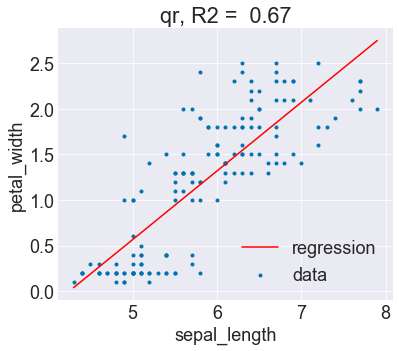

In [24]:
lin_reg_qr.linear_regression(['sepal_length'], 'petal_width', 'qr')
lin_reg_qr.scatter('sepal_length', 'petal_width', 'qr')
lin_reg_qr.show()

**Question 4:** How do your results compare to the built-in SciPy solver? Is this what you expected? Why or why not?

**Answer 4:**

This gives the same R2 as Scipy solver, which is expected becuase gradient descent should work as well as QR decomposition (at least on this small dataset). 

### Task 4b) Compare performance of the linear regression methods

- Implement `mean_sse` in `linear_regression.py`. **Run test code below**
- In the cell below, load in the brain network `brain.csv` dataset.
- Create `Data` and `LinearRegression` objects.
- Load in the list of variable names in the brain dataset (62)
- Do multiple linear regressions, separately for each of the linear regression methods that you have implemented (including `scipy`): Set all brain data variables except for the last one as the independent variables, the last variable is the depenendent variable.
- Compute the mean sum of squares error (MSSE) in the predictions made by each linear regression model and the actual y values.

**Equation for MSSE:** $$E = \frac{1}{N}\sum_{i=1}^N \left (y_i - \hat{y}_i \right )^2$$

#### Test Mean SSE

In [4]:
# Test with iris data
lin_reg_norm = linear_regression.LinearRegression(iris_data)
lin_reg_norm.linear_regression(['sepal_length'], 'petal_width', 'normal')
print(f'Your Iris mean SSE is {lin_reg_norm.mean_sse():.2f} and should be 0.19')

# Test with passing in random data
np.random.seed(0)
test_data = np.random.rand(iris_data.get_num_samples(), 1)
print(f'Your random data mean SSE is {lin_reg_norm.mean_sse(X=test_data):.2f} and should be 16.72')

Your Iris mean SSE is 0.19 and should be 0.19
Your random data mean SSE is 16.72 and should be 16.72


In [5]:
brain_data_fp = 'data/brain.csv'
brain_data = data.Data(brain_data_fp)

brain_var_names_fp = 'data/brain_var_names.txt'
with open(brain_var_names_fp) as f:
    line = f.readline()
    brain_var_names = line.split(',')

lin_reg = linear_regression.LinearRegression(brain_data)

lin_reg.linear_regression(brain_var_names[:-1], brain_var_names[-1], 'scipy')
msse_scipy = lin_reg.mean_sse()
lin_reg.linear_regression(brain_var_names[:-1], brain_var_names[-1], 'normal')
msse_normal = lin_reg.mean_sse()
lin_reg.linear_regression(brain_var_names[:-1], brain_var_names[-1], 'qr')
msse_qr = lin_reg.mean_sse()


print('MSSE for each method:')
print(f'scipy: {msse_scipy}')
print(f'normal: {msse_normal}')
print(f'QR: {msse_qr}')

MSSE for each method:
scipy: 5.962143997175509e-26
normal: 7449.574732612322
QR: 3.3020364993816476e-23


**Question 5:** What are the mean sum of squares errors for each of the regression methods on the brain data? Which method(s) do best and which do the worst **and why**?

**Answer 5:**

The summary stats has been printed above. THe SciPy method does best, while the normal method performs poorly. The SciPy method probably uses gradient descent to find the global minimum point of the loss function (which is guaranteed by the form of sqaured-error loss function), while for the normal method the matrix inversion probably does not work well on the brain data set (The reason for this is explored in extension 2). 

## Task 5: Polynomial Regression

We have been creating linear regression fits of form $y =c_0 + c_1x_1 + c_2x_2 + \ldots$, where $x_i$ are independent variables (columns of $A$) and $c_i$ are corresponding coefficients in $c$. However, this equation only allows us to fit with a line/plane. This may not be the best choice for all datasets.

In this task, you will generalize the linear regression model form to include higher-degree (>1) polynomial terms and explore how this may improve fits to complex data. For example, assume we're doing a single linear regression with independent variable $x_1$ and dependent variable $y$. A linear regression that fits data with a quadratic shape has the form$$y = c_0 + c_1x_1 + c_2x_1^2$$ 

### 5a) Implement polynomial regression

- Implement two methods: `LinearRegression::poly_regression` and `LinearRegression::make_polynomial_matrix` (*helper method*). To implement polynomial regression, recall that you add one or more "independent variables" to $A$, derived from the original column vector $x_1$. For example, if $A$ originally has a column vector for the independent variable $\vec{x_1}$ ($A = [\vec{x_1}]$) and we wanted to make the above quadratic model, we would append $x_1^2$ ($A = [\vec{x_1}, \vec{x_1^2}]$).
- Add support for plotting polynomials in `LinearRegression::scatter`. To do this, you are going to generalize the regression line to a regression polynomial (if `self.p > 1`).
    - Getting your polynomial "x" values: Duplicate your line sample points for $p$ columns then raise each column to the appropriate power.
    - Getting your polynomial "y" values: Use matrix multiplication with your polynomial regression model slopes and/or intercepts.
- Update `predict` to run `make_polynomial_matrix` on `X` to change it if `X` is not `None` and `self.p > 1`.

#### Test `make_polynomial_matrix`

In [6]:
test_A = np.r_[1:10].reshape((9, 1))
test_p = 3

# Test cubic
lin_reg = linear_regression.LinearRegression(data.Data())
print(f'Your polynomial matrix:\n{lin_reg.make_polynomial_matrix(test_A, 3)}')

true_mat = '''
[[  1.   1.   1.]
 [  2.   4.   8.]
 [  3.   9.  27.]
 [  4.  16.  64.]
 [  5.  25. 125.]
 [  6.  36. 216.]
 [  7.  49. 343.]
 [  8.  64. 512.]
 [  9.  81. 729.]]
'''
print('It should look like:\n', true_mat)

Your polynomial matrix:
[[  1.   1.   1.]
 [  2.   4.   8.]
 [  3.   9.  27.]
 [  4.  16.  64.]
 [  5.  25. 125.]
 [  6.  36. 216.]
 [  7.  49. 343.]
 [  8.  64. 512.]
 [  9.  81. 729.]]
It should look like:
 
[[  1.   1.   1.]
 [  2.   4.   8.]
 [  3.   9.  27.]
 [  4.  16.  64.]
 [  5.  25. 125.]
 [  6.  36. 216.]
 [  7.  49. 343.]
 [  8.  64. 512.]
 [  9.  81. 729.]]



### 5b) Fitting data with polynomial regression

- In the cell below, load in `poly_data_1.csv`, make a `Data` object, make a `LinearRegression` object based off it like usual.

In [7]:
poly_data_fp = 'data/poly_data_1.csv' 
poly_data = data.Data(poly_data_fp)

lin_reg = linear_regression.LinearRegression(poly_data)

#### (i) Run polynomial regression on `poly_data_1` and plot results with `p=1`

- Run `poly_regression` with the polynomial degree $p = 1$. Solve using the normal equations.
- Use `scatter` to plot the results below.
- Print out the mean sum of squares error.

The plot created by running the below cell should "look right" to you.

MSSE: 59.599210975703954


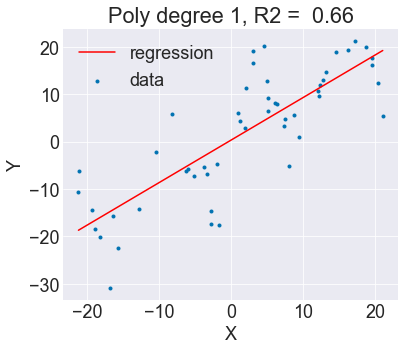

In [8]:
lin_reg.poly_regression('X', 'Y', 1, 'normal')

lin_reg.scatter('X', 'Y', title='Poly degree 1')
print(f'MSSE: {lin_reg.mean_sse()}')

#### (ii) Higher degree polynomials

In the cell below,
- Run `poly_regression` on the same datset with `p = 5`.
- Plot the results.
- Print out the mean squared error.

MSSE: 49.807782194744085


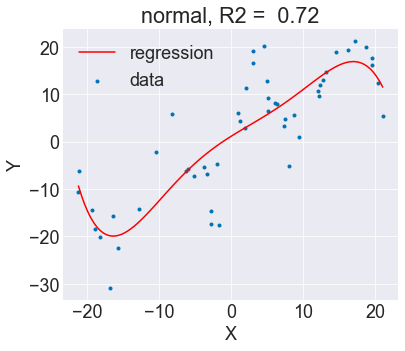

In [9]:
lin_reg.poly_regression('X', 'Y', 5, 'normal')

print(f'MSSE: {lin_reg.mean_sse()}')

lin_reg.scatter_poly('X', 'Y', 'normal')

In [10]:
for i in range(1, 5+1):
    lin_reg.poly_regression('X', 'Y', i, 'scipy')
    print(f'p = {i}, MSSE = {lin_reg.mean_sse()}, R2 = {lin_reg.R2}')

p = 1, MSSE = 59.599210975703954, R2 = 0.6600388084752987
p = 2, MSSE = 59.40840801582888, R2 = 0.6611271719036671
p = 3, MSSE = 53.4882874512343, R2 = 0.694896263946344
p = 4, MSSE = 52.62252388256084, R2 = 0.6998346852704935
p = 5, MSSE = 49.807782194744085, R2 = 0.7158903162488051


**Question 6:** Describe the fit compared to `p=1` â€” is it better or worse? Why?

**Answer:** Compared to p=1, polynomials of 5 degrees fit the trainig data better because the MSSE is lower. The reason for the better fit is that 5 degrees has more freedom to tweat its shape to become closer to what the data looks like. 



**Question 7:** Describe what happens as you experiment with the polynomial degree between 1 and 5.

**Answer:** As degress incerase, MSSE decreases and R2 increases, indicating that the fit is getting better on poly_data_1. 

#### (iii) Check overfitting

Now you will check to see how the $p=5$ polynomial regression model generalizes to new data. 

- Load in `poly_data_2.csv`, which is the 2nd half of the `poly_data_1` dataset, make a new `Data` object, etc.
- Run `scatter` to show a scatterplot and the polynomial regression of the `poly_data_2` data, but use the polynomial regression model fit to the `poly_data_1`. Do this by replacing the `Data` object in `LinearRegression` object with the one holding `poly_data_2`. Use `set_data()`; do NOT run `poly_regression` again. You want to use the same fitted slopes/intercept from `poly_data_1`.
- Print out the mean sum of squared error obtained when predicting the `poly_data_2` using the regression model fit on `poly_data_1`. Do this by passing in the data column `X` selected from `poly_data_2` as a column vector ndarray.

p = 5, MSSE = 394.1919126185123


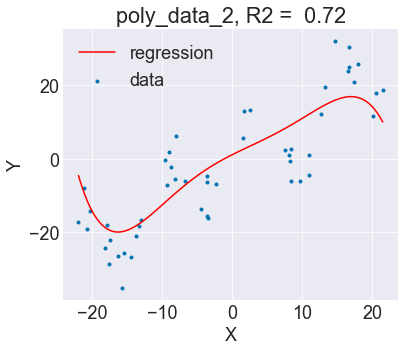

In [11]:
lin_reg = linear_regression.LinearRegression(data.Data('data/poly_data_1.csv'))
lin_reg.poly_regression('X', 'Y', 5)

poly_data_2_fp = 'data/poly_data_2.csv'
poly_data_2 = data.Data(poly_data_2_fp)

lin_reg.set_data(poly_data_2) 
lin_reg.scatter_poly('X', 'Y', 'poly_data_2') 

x_data_name = 'X'
    
# predict
print(f'p = 5, MSSE = {lin_reg.mean_sse(poly_data_2.select_data(x_data_name), 5)}')

**Question 8:** Describe how the fitted coefficients obtained for `poly_data_1` do on `poly_data_2`. Do they do a good or bad job? Why?

**Answer 8:** Bad job, in terms of MSSE scores. The polynomial of 5 degrees trained on data set 1 overfits the training data (memorizes the shape of data set 1 too well) and thus loses its predictive ability on new data.  

#### (iv) Even higher degree polynomials

In the cell below, experiment with fitting and plotting `poly_data_1` again, but this time with an even higher degree polynomial `p=19`.

Be sure to:
- Fit the higher degree polynomial to the `poly_data_1` data.
- Plot the results for both `poly_data_1` and `poly_data_2`.
- Print out the MSSE for both `poly_data_1` and `poly_data_2`
- Like you did with `p = 5`, experiment how the results transfer to `poly_data_2` (i.e. do NOT re-run `poly_regression` after fitting coefficients to `poly_data_1`.

**Question 9:** What's going on with the higher degree polynomial fit and $R^2$?

**Answer 9:** The polynomial fit becomes more tailored to the shape of the data (crossing as many data points as it can that it becomes more like interpolation than regression). $R^2 = 0.93$ becomes much larger such that it is close to 1.

**Question 10:** Compare the results for `poly_data_1` and `poly_data_2`. Back up your observations with numbers (e.g. MSSE).

**Answer 10:** It is clear that the polynomial fit with 19 degrees overfits poly_data_1 and thus does not predict poly_data_2 very well. The MSSE for poly_data_1 is 11.52, which is very small, while that for poly_data_2 is 538.25. 

0.9342788500941367
MSSE = 11.521693582841829


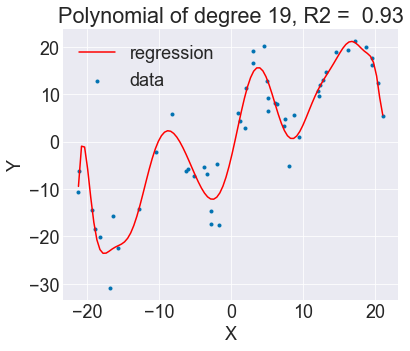

In [12]:
lin_reg.set_data(poly_data)
lin_reg.poly_regression('X', 'Y', 19)
lin_reg.scatter_poly('X', 'Y', 'Polynomial of degree 19')

print(lin_reg.R2)

print(f'MSSE = {lin_reg.mean_sse()}')

p = 19, poly_data_2 MSSE = 538.2489261190792


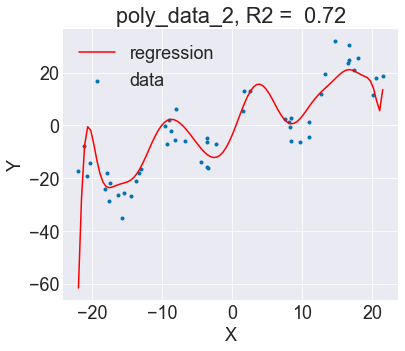

In [13]:
lin_reg.set_data(poly_data_2) 
lin_reg.scatter_poly('X', 'Y', 'poly_data_2') 

x_data_name = 'X'
print(f'p = 19, poly_data_2 MSSE = {lin_reg.mean_sse(poly_data_2.select_data(x_data_name), 19)}')

## Extensions

To receive credit for any extension, you must:
- Not modify / prevent any code from the core project from working (e.g. make a copy before changing). In other words, **the notebook test code should still work!**
- **You must describe what you did and what you found in detail**. This includes a summary of parameter values used in your simulations.
- Include (*labeled!*) plots and/or numbers to present your results.
- Write up your extensions below or in a separate notebook.

**Rule of thumb: one deep, thorough extension is worth more than several quick, shallow extensions!**

**Reminder:** Give credit to all sources, including anyone that you consulted.

### 1. Your own data

- Run linear regression on datasets that interest you. Identify your hypotheses about the association between variables and test them out. Make plots and report all relevant metrics fit.

In Project 1 I raised the question if there is any association between availability of a listed house and its number of reviews, the assumption being that the more days a house is available the the more likely it is able to attract customers and the more number of reviews.

In [14]:
airbnb_data = data.Data('data/AB_NYC_2019.csv')
lin_reg = linear_regression.LinearRegression(airbnb_data)

MSSE 1925.9791828975763


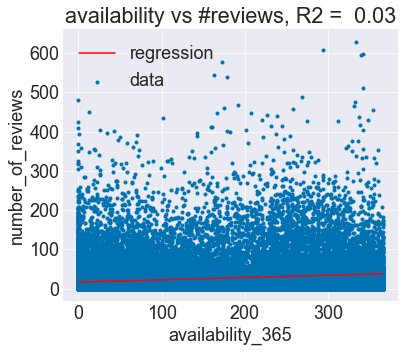

In [15]:
lin_reg.linear_regression('availability_365', 'number_of_reviews')
lin_reg.scatter('availability_365', 'number_of_reviews', 'availability vs #reviews')
print(f'MSSE {lin_reg.mean_sse()}')

From the figure above, however, it turns out the two variables are not strongly associated, both in terms of $R^2$ and MSSE. $R^2 = 0.03$, and $MSSE = 1925.98$. The reason I only tried linear regression on the data is that from the distribution of the data it is clear that the data is uniformly distributed and thus polynomial fit will also not be able to capture the intrinsic relationships. 

Another variable about reviews per month aroused my interest and I expect there be strong correlation between reviews per month and the total number of reviews, because, after all, the total number of reviews is accumulated months after months. 

MSSE 1295.2223091234891


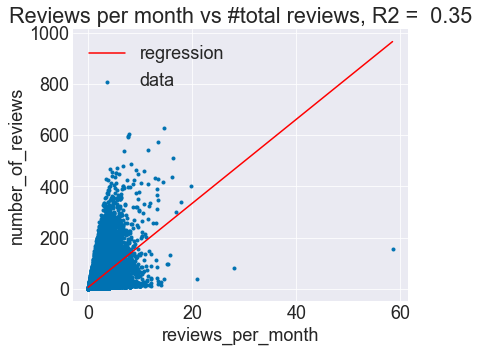

In [16]:
lin_reg.linear_regression('reviews_per_month', 'number_of_reviews')
lin_reg.scatter('reviews_per_month', 'number_of_reviews', 'Reviews per month vs #total reviews')
print(f'MSSE {lin_reg.mean_sse()}')

The $R^2$ statistic, however, is not very ideal. But clearly the data is shaped in a way that there should be a stronger association between them. Looking at the figure, we can see that the problem probably lies with the outlier, which located on the far right of the figure. Every month has at most 30 days, while the outlier shows there are nearly 60 reviews in a month, indicating some problems with the original data. 

Thus if we remove that outlier and rerun the regression, we get the following results. 

MSSE 1281.4298453576953


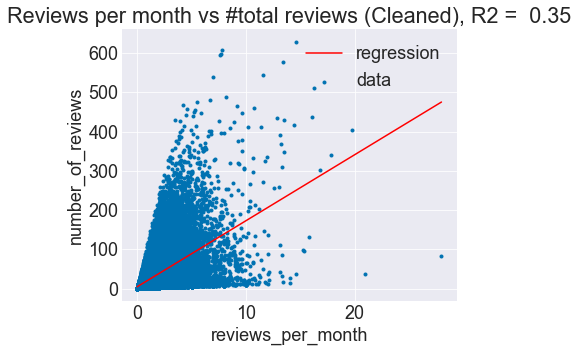

In [17]:
reviews_per_month_idx = airbnb_data.get_header_indices('reviews_per_month')[0]
old_data = airbnb_data.data
new_data = old_data[old_data[:, reviews_per_month_idx] <= 31]

airbnb_data_cleaned = data.Data(data=new_data, headers=airbnb_data.headers, header2col=airbnb_data.header2col)

lin_reg.set_data(airbnb_data_cleaned)
lin_reg.linear_regression('reviews_per_month', 'number_of_reviews')
lin_reg.scatter('reviews_per_month', 'number_of_reviews', 'Reviews per month vs #total reviews (Cleaned)')
print(f'MSSE {lin_reg.mean_sse()}')

However, even though the outlier is removed, there is not improvement in $R^2$ and MSSE. This means that probably there is weak association between reviews per month and total number of reviews. Based on the figure, we can see that the majority of data points that have a large total number of reviews receive only a moderate number of reviews per month, indicating that possibly the time a house is listed bears more relationship to the total number of reviews. 

On the other hand, this indicates that the linear regression is quite robust to outliers given that the presence of an outlier does not significantly affect the fit.


### 2. Linear regression algorithm comparison

- Compare the linear regression methods that you implemented on a dataset of your choice.
- Research and implement matrix condition number. Find a dataset with a poor matrix condition number and then compare the regression methods. Which does best and why?

In [18]:
brain_data = data.Data('data/brain.csv')
raw_data = brain_data.data[:, :60]

In [19]:
cond_N = np.linalg.norm(raw_data)*np.linalg.norm(np.linalg.inv(raw_data))
print(f'Condition number of brain data: {cond_N}')

Condition number of brain data: 3660.7191023264645


Because to compute the condition number of data we need to compute the inverse of the matrix, we dropped the last two columns of brain data and use the first 60 columns (but with the last two columns the condition number should still be very bad). The condition number is 3660 which is way above 1. This indicates that the matrix is not stable to changes in inputs and suggests that normal methods, which needs to find inverses of the matrix, might not perform well on the data.

In [20]:
lin_reg = linear_regression.LinearRegression(brain_data)
headers = brain_data.get_headers()


lin_reg.linear_regression(headers[:-1], headers[-1], 'scipy')
print(f'scipy R2 {lin_reg.R2}, MSSE {lin_reg.mean_sse()}')

lin_reg.linear_regression(headers[:-1], headers[-1], 'normal')
print(f'normal R2 {lin_reg.R2}, MSSE {lin_reg.mean_sse()}')

lin_reg.linear_regression(headers[:-1], headers[-1], 'qr')
print(f'qr R2 {lin_reg.R2}, MSSE {lin_reg.mean_sse()}')

scipy R2 1.0, MSSE 5.962143997175509e-26
normal R2 -3.3309809811390503, MSSE 7449.574732612322
qr R2 1.0, MSSE 3.3020364993816476e-23


As the outputs above suggest, because the brain dataset has poor condition number, inversion of the dataset does not perform well and reuslt in large round-off errors when computing, so large that MSSE for normal methods is $7449$, while that for the other two have $MSSE < 3.3 \times 10^{-23}$.

On the other hand, SciPy method, which probbaly relies on gradient descent methods to find the global minimum of the loss function and thus in this way computes the parameters for regression, performs better than QR decomposition, given that the MSSE of SciPy method is much smaller than that of QR decomposition.

### 3. Confidence intervals or other kinds of error bars on linear regression plots

- Add the option to plot 95% confidence intervals on the linear regression predictions in your plot functions (e.g. `scatter`).

To find the 95% CI for linear regression predictions, we calculate the 95% CI for each of the slope coefficients by using the equation 

$$ ( m_i - z_{0.025\%} \times SE(m_i), m_i + z_{0.025\%} \times SE(m_i) ) $$ 

where $ z_{0.025} = 1.96 $ given that the sample size is large enough, and $ SE(m_i) $ is defined as 

$$ SE(m_i) = \frac{\sqrt{\sum(y_j - \hat{y_j}}}{\sqrt{\sum(x_i - \bar{x_i})} \sqrt{n-2}} $$ 

In `scatter()` method, I added an optional parameter `CI` which defaults to `False`. If turned on, it will plot the confidence internval using `fill_between` from matplotlib. The alpha of the color is set low so that the plotted interval would not cover the data points. 

As an example, I plotted the figure featuring "sepal length vs petal width".

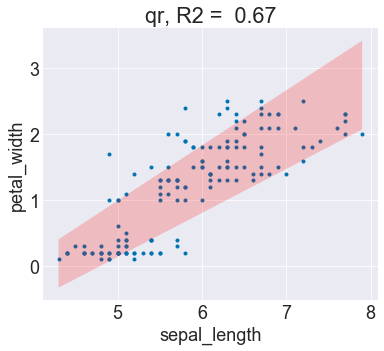

In [21]:
lin_reg = linear_regression.LinearRegression(iris_data)

lin_reg_qr.linear_regression(['sepal_length'], 'petal_width', 'qr')
lin_reg_qr.scatter('sepal_length', 'petal_width', 'qr', CI=True)
lin_reg_qr.show()

We can see that given 95% CI, most data points fall into the confidence intervals, indicating that our estimates are moderately good, as there are still some data points that are outside the range. 

### 4. Overfitting

- Run polynomial regression on other datasets. What degree polynomial works well? When do you overfit?

degree 1, R2 = 0.07665393163630863, train MSSE = 178.39604656353018, test MSSE = 4662.211191003227
degree 2, R2 = 0.13068381785269778, train MSSE = 167.95714567086438, test MSSE = 5057.66917489896
degree 3, R2 = 0.15161111696246643, train MSSE = 163.91386487469308, test MSSE = 11132.475708767639
degree 4, R2 = 0.15962856184075658, train MSSE = 162.36484601943042, test MSSE = 125213.96920565097
degree 5, R2 = 0.165556821433544, train MSSE = 161.21947040069867, test MSSE = 5448456.006568138
degree 6, R2 = 0.16837691600264282, train MSSE = 160.67461106864553, test MSSE = 98638066.25388539
degree 7, R2 = 0.16928942883721898, train MSSE = 160.4983080683898, test MSSE = 2463070547.166843
degree 8, R2 = 0.1701308009593363, train MSSE = 160.3357498841756, test MSSE = 88127321575.55876
degree 9, R2 = 0.17066832958801226, train MSSE = 160.23189610111848, test MSSE = 5723270697221.389


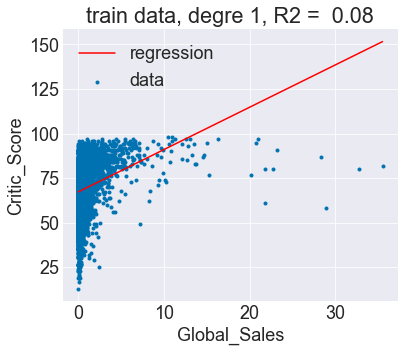

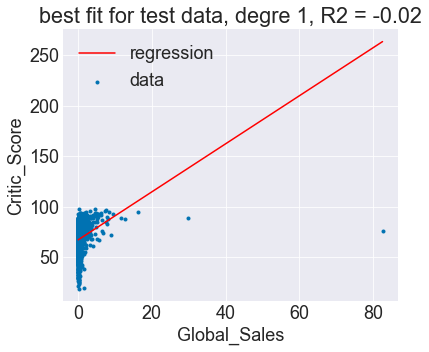

In [22]:
sales_data = data.Data('data/Video_Games_Sales.csv')
whole_data = sales_data.data

critic_score_idx = sales_data.get_header_indices(['Critic_Score'])[0]
whole_data = whole_data[whole_data[:, critic_score_idx] > 0]

N = whole_data.shape[0]
np.random.seed(10)
np.random.shuffle(whole_data)
train_data = whole_data[:int(8*N/10), :]
test_data = whole_data[int(8*N/10):, :]

sales_train_data = data.Data(data=train_data, headers=sales_data.headers, header2col=sales_data.header2col, )
sales_test_data = data.Data(data=test_data, headers=sales_data.headers, header2col=sales_data.header2col)

lin_reg = linear_regression.LinearRegression(sales_train_data)
x_data = sales_test_data.select_data('Global_Sales') 

best_fit_idx = 0 
best_fit_score = 100000
for i in range(1, 10):
    lin_reg.set_data(sales_train_data)
    lin_reg.poly_regression('Global_Sales', 'Critic_Score', p=i, method='scipy')
    train_msse = lin_reg.mean_sse()
    R2 = lin_reg.R2
    
    lin_reg.set_data(sales_test_data)
#     lin_reg.scatter_poly('Global_Sales', 'Critic_Score', f'Polynomial of degree {i}')
    test_msse = lin_reg.mean_sse(x_data, poly=i, original_y=sales_test_data.select_data('Global_Sales'))
    print(f'degree {i}, R2 = {R2}, train MSSE = {train_msse}, test MSSE = {test_msse}')
    if test_msse < best_fit_score:
        best_fit_idx = i 
        best_fit_score = test_msse

lin_reg.set_data(sales_train_data)
lin_reg.poly_regression('Global_Sales', 'Critic_Score', p=best_fit_idx, method='scipy')
lin_reg.scatter_poly('Global_Sales', 'Critic_Score', f'train data, degre {best_fit_idx}')
lin_reg.set_data(sales_test_data)
lin_reg.scatter_poly('Global_Sales', 'Critic_Score', f'best fit for test data, degre {best_fit_idx}')


    

I have used a dataset that records sales of games and ratings on them given by professional judges. I am trying to fit a polynomial between the two variables. I have tried polynomials from degrees 1 to 9 (given the shape of data higher degrees do not really help). The best fit is polynomial of degree 1, which has the lowest MSSE. 

As degrees increase, even though MSSE for training data does not increase, MSSE for testing data skyrockets, suggesting that degrees even over 2 are overfitting the training data. 